# Importing packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

from scipy.stats import expon, lognorm, loguniform, randint, uniform

import altair as alt
alt.renderers.enable('kaggle')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pickle

# Reading dataset

In [2]:
data = pd.read_csv(r"Unselphish-Datasets\spam.csv")
X = data['Message']  # Features
y = data['Category']  # Labels
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Data splitting into train and test

In [3]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2018)

train_df

,Category,Message
1901,ham,And miss vday the parachute and double coins??...
5528,ham,Its just the effect of irritation. Just ignore it
3581,ham,Have a lovely night and when you wake up to se...
3960,ham,Have a nice day my dear.
403,ham,The hair cream has not been shipped.
...,...,...
2196,ham,V-aluable. A-ffectionate. L-oveable. E-ternal....
917,ham,Was actually about to send you a reminder toda...
2825,ham,No need to buy lunch for me.. I eat maggi mee..
2662,ham,Do you know when dad will be back?


# EDA

In [4]:
train_df.shape

(4457, 2)

In [5]:
pd.DataFrame(data['Category'].value_counts(normalize=True), index=None)

,proportion
Category,
ham,0.865937
spam,0.134063


- We have $4457$ training example texts and observe that only $13.4%$ is `spam`. 
- We can classify this as class imbalance.
- We can tackle this by two methods
    1. Subsampling and increasing the ratio of `spam` marked emails.
    2. Use metrics like Recall, Precision, F-1, ROC-AUC score to judge our model.
- Here, we would use the F-1 score to maintain a balance between recall and precision scores. Choosing recall or precision instead of selecting F-1 is context dependent.

C:\Users\Anutosh\AppData\Local\Temp\ipykernel_11088\3752835905.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
C:\Users\Anutosh\AppData\Local\Temp\ipykernel_11088\3752835905.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


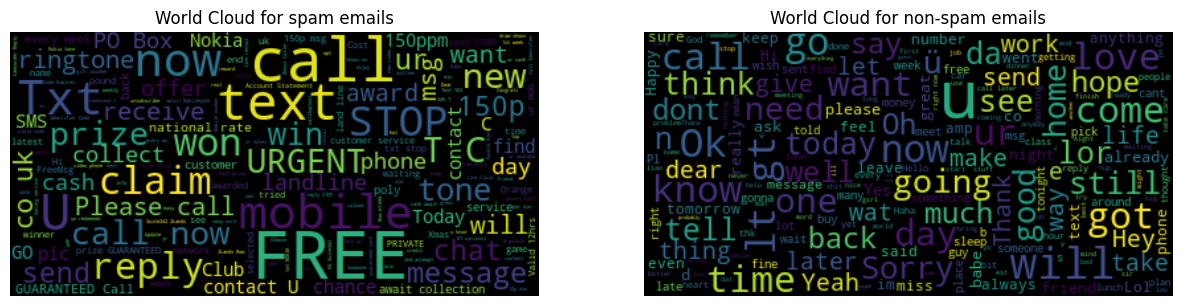

In [6]:
string_spam = ' '.join([elem for elem in train_df.query('Category == "spam"').Message.tolist()])
string_ham = ' '.join([elem for elem in train_df.query('Category == "ham"').Message.tolist()])

wordcloud_spam = WordCloud(max_font_size=50).generate(string_spam)
wordcloud_ham = WordCloud(max_font_size=50).generate(string_ham)

f, axs = plt.subplots(2,2,figsize=(15,15)) 
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("World Cloud for spam emails")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("World Cloud for non-spam emails")

plt.show()

# Using CountVectorizer to handle text column

In [7]:
X_train, y_train = train_df['Message'], train_df['Category']
X_test, y_test = test_df['Message'], test_df['Category']

- We transform our text column using sklearn's `CountVectorizer`. Alterante method to do so is TD-IDF which focuses on frequencies of words and its proportions in the document. `CountVectorizer` is used for calculing an individual word count in the text.
- We use two parameters of `CountVectorizer` which are:
    1. `max_features` limits the number of distinct individual tokens/words we want to be counted.
    2. `stop_words`=english eliminates the common English words like is, a, the, etc.
- Ultimately, we fit and tranform the data to observe the columns of the transformed data.
- `get_feature_names` is used to extract the word names of the top 1000 occuring max_features.

In [8]:
vec = CountVectorizer(max_features=1000, stop_words='english')

X_counts = vec.fit_transform(X_train)
bow_sms = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names_out(), index=X_train
)
bow_sms

,00,000,02,03,04,0800,08000839402,08000930705,08712460324,08718720201,...,yeah,year,years,yep,yes,yesterday,yo,yr,yrs,yup
Message,,,,,,,,,,,,,,,,,,,,,
And miss vday the parachute and double coins??? U must not know me very well...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Its just the effect of irritation. Just ignore it,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Have a lovely night and when you wake up to see this message, i hope you smile knowing all is as should be. Have a great morning",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Have a nice day my dear.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The hair cream has not been shipped.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"V-aluable. A-ffectionate. L-oveable. E-ternal. N-oble. T-ruthful. I-ntimate. N-atural. E-namous. Happy ""VALENTINES DAY"" in advance",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Was actually about to send you a reminder today. Have a wonderful weekend,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No need to buy lunch for me.. I eat maggi mee..,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
bow_sms.shape

(4457, 1000)

# Visualizing the transformed data

In [10]:
visualize_sms = bow_sms.T
visualize_sms['length'] = visualize_sms.sum(axis=1)
visualize_sms = pd.DataFrame(visualize_sms.loc[:, 'length']).reset_index()
visualize_sms = visualize_sms.sort_values(['length'], ascending=False)

import altair as alt
alt.Chart(visualize_sms.iloc[0:20,:]).mark_bar().encode(
y=alt.Y('index', sort='x'),
x='length')

alt.Chart(...)

We can see some misspelled words such as `ur` and `gt` which could be short forms for your and got. There are other common recurring words such as `just`, `free`, `ok` and `it`.

## 1. Choosing max_features:
With lesser number of features, we are likely to underfit the training data as we run the risk of missing out on key features for modeling the dataset. Overfitting is likely to happen when we take a lot more words/features which add to the complexity of the model.

## 2. Problems with english stop words:
Words like `the` can sometimes be important to mark important proper nouns such as `The Taj Mahal`. So, we should use this feature with a pinch of salt. A better approach would be to pass a relevant list of such stop_words instead of using the default enlgish stop words.

# Building our ML model

We have defined two scoring metrics `accuracy` (default) and `ROC-AUC` score for assessing the model. `ROC-AUC` score gives us a fair evaluation of the model performance of our set due to the class imbalance. Another reason for choosing `ROC-AUC` over `F1` score is that the former gives score over different thresholds while `F1` value is for the default threshold.

In [11]:
dummy_model = DummyClassifier(strategy='prior')
dummy_model.fit(X_train, y_train)

scoring_metrics = ["accuracy", "roc_auc"]

results = pd.DataFrame(cross_validate(dummy_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics))
pd.DataFrame(results.mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.003361,0.027067,0.866727,0.866727,0.5,0.5


- With Dummy Classifier, we get 86.63% training accuracy and 86.63% validation accuracy. 
- We get high scores because using the `prior` strategy, DummyClassifier marks all its targets as the most occuring target value which is `ham` which incidentally makes up around more than 80% of the dataset.
- The score are almost the same maybe due to the ratio of spam and non-spam messages being evenly distributed between train and validation sets.
- ROC-AUC score of 0.5 means that our model is as good as taking flipping a coin. It is predicting random class or constant class for all the examples.

In [12]:
pipe = make_pipeline(CountVectorizer(stop_words='english', max_features=1000), LogisticRegression())
pipe.fit(X_train, y_train)

results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics))
pd.DataFrame(results.mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.117732,0.045334,0.978014,0.989343,0.986629,0.998289


Using CountVectorizer with stop_words='english' and max_features=1000 and Logistic Regression, we get 98.91% training accuracy and 97.64% validation accuracy. We get better train and validation scores with Logistic Regression in comparison to DummyClassifier.

# Hyperparameter Optimization

We actually have two different sets of hyperparamters(total 4):
1. CountVectorizer has two: **max_features** and **stop_words**.
2. We use two for Logisitic Regression: 
    * **C**: C is regularization parameter and the strength of the regularization is inversely proportional to C. Must be strictly positive.
    * **penalty**: We will be using two choices here: 
        1. `l2` : add a L2 penalty term and it is the default choice
        2. `l1` : which is L1 penalty which can be used to reduce sparse data features. 

## 1. Making a grid of different hyperparameter values

In [13]:
X_train

1901    And miss vday the parachute and double coins??...
5528    Its just the effect of irritation. Just ignore it
3581    Have a lovely night and when you wake up to se...
3960                             Have a nice day my dear.
403                  The hair cream has not been shipped.
                              ...                        
2196    V-aluable. A-ffectionate. L-oveable. E-ternal....
917     Was actually about to send you a reminder toda...
2825      No need to buy lunch for me.. I eat maggi mee..
2662                   Do you know when dad will be back?
1274    network operator. The service is free. For T &...
Name: Message, Length: 4457, dtype: object

In [14]:
pipe_lr = make_pipeline(CountVectorizer(), LogisticRegression())

param_dists = {
    "countvectorizer__max_features": randint(low=100, high=2000),
    "countvectorizer__stop_words": ['english', None],
    "logisticregression__C": loguniform(1e-3, 1e3),
    "logisticregression__class_weight": ['balanced', None],
    "logisticregression__max_iter": np.arange(500, 2000, 50)
}

## 2. Using Randomized Search to get the best hyperparameter values

- RandomizedSearch is better than using GridSearch because of the randomness attached to the selection of hyperparameter values over a range.
- Explanation of the arguments used:
    1. n_iter: number of different sets of hyperparameter values to be run/ iterations to be done.
    2. n_jobs: setting it to -1 allows multiple cores of computers to run different iterations simultaneously.
    3. refit: this is one of the elements from the scoring list (['accuracy', 'roc_auc']), which is to be used to rank the best model.

In [15]:
model_random = RandomizedSearchCV(
        pipe_lr,
        param_dists,
        n_iter=50,
        n_jobs=-1,
        random_state=2018,
        return_train_score=True,
        scoring=scoring_metrics,
        refit="roc_auc"
    )
model_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025690D99510>,
                                        'countvectorizer__stop_words': ['english',
                                                                        None],
                                        'logisticregression_...bject at 0x0000025690D98810>,
                                        'logisticregression__class_weight': ['balanced',
                                                                             None],
                                        'logisticregression__max_iter': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950])},
                   random_state=2018, refit='roc_auc', return_train_score=True,
                   scoring=['accuracy', 'roc_auc'])

In [16]:
results = pd.DataFrame(model_random.cv_results_)
results = results.loc[:, ['param_countvectorizer__max_features', 'param_countvectorizer__stop_words',
                          'param_logisticregression__C', 'param_logisticregression__class_weight',
                          'param_logisticregression__max_iter', 'mean_train_roc_auc', 'mean_test_roc_auc',
                          'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_roc_auc']] 
results.sort_values(by='mean_test_roc_auc', ascending=False).T

,13,20,10,5,49,24,16,35,26,36,...,9,29,23,18,46,38,44,42,25,12
param_countvectorizer__max_features,1959,1629,1411,1755,1933,1061,1061,1421,1900,1435,...,209,838,754,1962,930,223,127,1033,1127,122
param_countvectorizer__stop_words,english,english,english,english,english,english,english,None,english,None,...,None,None,None,None,None,None,english,None,None,None
param_logisticregression__C,1.428699,0.903959,0.264523,4.581116,0.076452,0.868685,10.183319,0.852521,0.006794,1.078682,...,79.335113,196.790578,0.004136,0.002799,0.002949,0.00378,0.012252,0.001229,0.001043,0.001618
param_logisticregression__class_weight,None,None,None,None,None,balanced,None,None,balanced,None,...,None,balanced,None,None,None,balanced,balanced,None,None,balanced
param_logisticregression__max_iter,1100,900,1100,1500,1250,1150,1400,650,1250,500,...,1150,1450,600,700,1400,700,1300,1000,750,600
mean_train_roc_auc,0.999333,0.998847,0.997113,0.99937,0.994799,0.998841,0.999104,0.998484,0.990169,0.998587,...,0.997394,0.999977,0.971559,0.97019,0.96924,0.969542,0.966947,0.962712,0.961915,0.950674
mean_test_roc_auc,0.987208,0.987126,0.986908,0.986472,0.986203,0.985621,0.983736,0.983112,0.983054,0.982924,...,0.968334,0.966624,0.966526,0.964957,0.964375,0.963603,0.961301,0.958053,0.957169,0.946257
mean_train_accuracy,0.993774,0.99024,0.9802,0.997925,0.966065,0.995569,0.997925,0.993157,0.976722,0.994727,...,0.990521,0.999327,0.8872,0.873009,0.873682,0.948901,0.957595,0.866727,0.866727,0.92495
mean_test_accuracy,0.979809,0.978687,0.972406,0.981603,0.956252,0.980705,0.980929,0.979358,0.973078,0.979806,...,0.965896,0.965225,0.883778,0.872335,0.873232,0.948846,0.954006,0.866727,0.866727,0.92641
rank_test_roc_auc,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50


## 3. Visualizing all the models trained by Randomized Search

In [17]:
roc_auc_plot = alt.Chart(results,
          title='Distribution of ROC-AUC score basis hyperparameters'
          ).mark_point().encode(
    x=alt.X('param_countvectorizer__max_features',
            title='max_features'),
    y=alt.Y('mean_test_roc_auc',
            title='ROC-AUC Validation score',
            scale=alt.Scale(zero=False)),
    color=alt.Color('param_logisticregression__C',
                    title='C',
                    scale=alt.Scale(reverse=True)),
    size=alt.Size('param_logisticregression__max_iter',
                  title='max_iter'))

accuracy_plot = alt.Chart(results,
          title='Distribution of Accuracy score basis hyperparameters'
          ).mark_point().encode(
    x=alt.X('param_countvectorizer__max_features',
            title='max_features'),
    y=alt.Y('mean_test_accuracy',
            title='Accuracy Validation score',
            scale=alt.Scale(zero=False)),
    color=alt.Color('param_logisticregression__C',
                    title='C',
                    scale=alt.Scale(reverse=True)),
    size=alt.Size('param_logisticregression__max_iter',
                  title='max_iter'))

accuracy_plot | roc_auc_plot

alt.HConcatChart(...)

The above plots show that:
- Lower values of `C`, correspond to higher ROC-AUC score
- Higher number of `max_features`, correspond to higher ROC-AUC score

The code below prints all the best hyperparameter values and the scores associated with it.

In [18]:
best_model = model_random.best_estimator_

final_results = dict(results.sort_values(['rank_test_roc_auc']).reset_index(drop=True).iloc[0,:])
for key, value in final_results.items():
    print(f"{key}: {value}")

param_countvectorizer__max_features: 1959
param_countvectorizer__stop_words: english
param_logisticregression__C: 1.4286993917598214
param_logisticregression__class_weight: None
param_logisticregression__max_iter: 1100
mean_train_roc_auc: 0.9993333280191068
mean_test_roc_auc: 0.9872077528587744
mean_train_accuracy: 0.9937738450804268
mean_test_accuracy: 0.9798088005113417
rank_test_roc_auc: 1


Our final ROC_AUC valdiation score (called test score here) is slightly better than the default case in `Section 6`.

## 4. Examine important features associated with the model

Since, we have used Logistic Regression as our model, which is interpretable by looking at the coefficient value. The default class is `ham` as shown below which is associated with the `0` value of probability. The higher values of feature coefficients mean how positively or negatively do the feature increase or decrease the possibility of getting a `spam` message.

In [19]:
best_model.named_steps["logisticregression"].classes_

array(['ham', 'spam'], dtype=object)

In [22]:
best_model.fit(X_train, y_train)
text_columns = best_model.named_steps["countvectorizer"].get_feature_names_out()
coefs = {
    "coefficient": best_model.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(best_model.named_steps["logisticregression"].coef_.flatten().tolist()),
 }
coef_df = pd.DataFrame(coefs, index=text_columns).sort_values("magnitude", ascending=False)
coef_df.head(n=10)


pickle.dump(best_model, open(r'..\Spam_Model_LoR.sav', 'wb'))

We observe that a lot of the features associated with `spam` are:  
txt, uk, service, claim, free, etc which are acutally present in `spam` messages. Misspellings such as txt are common in spam mails.

# Evaluating the best model on test set

In [23]:
best_model.score(X_test, y_test)

0.979372197309417

In [24]:
input_mail = ["Win upto 90% discount on the latest model of iphone. Be the winner! Message on the given mobile number to claim your reward!"]

# making prediction
prediction = best_model.predict(input_mail)
pred_percent = best_model.predict_proba(prediction)
print(prediction)


if (prediction[0]==1):
  print('Ham mail')

else:
  print('Spam mail')

['spam']
Spam mail
